In [10]:
import wandb
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import binarize


from models import MLP, get_resnet, MultiScaleModel
from losses import an_full_loss, weighted_loss
from data.Datasets import PatchesDatasetCooccurrences, MultiScalePatchesDatasetCooccurrences
from data.PatchesProviders import MultipleRasterPatchProvider, RasterPatchProvider, JpegPatchProvider

In [3]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"DEVICE: {dev}\n")

DEVICE: cuda



In [69]:
run_name = '0208_MLP_env_1_weighted_loss_1'
# log_wandb
# wandb_project
wandb_id=None
random_bg_path=None 
val_occ_path=pa_path
n_max_low_occ=50
patch_size=1 
covariates = [bioclim_dir, soil_dir, landcover_path]
model='MLP'
n_layers=5 
width=1280
n_conv_layers=2
n_filters=[32, 64]
kernel_size=3 
pooling_size=1
dropout=0.5
loss='weighted_loss'
lambda2=1
n_epochs=150
batch_size=128
learning_rate=1e-3
seed=42

In [70]:
print(f"\nLoading model from checkpoint")
checkpoint = torch.load(f"models/{run_name}/last.pth")
checkpoint['epoch'] 


Loading model from checkpoint


149

In [72]:
flatten = True if model == 'MLP' else False
print(f"\nMaking patch providers for covariates: size={patch_size}x{patch_size}, flatten={flatten}")
providers = []
for cov in covariates:
    print(f"\t - {cov}")
    if 'SatelliteImages' in cov:
        if flatten and patch_size != 1: 
            exit("jpeg patch provider for satellite images cannot flatten image patches")
        providers.append(JpegPatchProvider(cov, size=patch_size))
    elif '.tif' in cov:
        providers.append(RasterPatchProvider(cov, size=patch_size, flatten=flatten))
    else:
        providers.append(MultipleRasterPatchProvider(cov, size=patch_size, flatten=flatten))
    


Making patch providers for covariates: size=1x1, flatten=True
	 - data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/
	 - data/full_data/EnvironmentalRasters/Soilgrids/
	 - data/full_data/EnvironmentalRasters/LandCover/LandCover_MODIS_Terra-Aqua_500m.tif


In [73]:
train_data = PatchesDatasetCooccurrences(occurrences=train_occ_path, providers=providers)
n_species = train_data.n_species

input_shape = train_data[0][0].shape
print(f"input shape = {input_shape}")

n_max_low_occ = 50
low_occ_species = train_data.species_counts[train_data.species_counts <= n_max_low_occ].index
low_occ_species_idx = np.where(np.isin(train_data.species, low_occ_species))[0]
print(f"nb of species with less than {n_max_low_occ} occurrences = {len(low_occ_species_idx)}")

nb items = 795688
nb species = 2088
input shape = (41,)
nb of species with less than 50 occurrences = 658


In [74]:
val_data = PatchesDatasetCooccurrences(occurrences=val_occ_path, providers=providers, species=train_data.species)

nb items = 7438
nb species = 2088


In [75]:
if model == 'MLP':
    model = MLP(input_shape[0], n_species, n_layers, width, dropout).to(dev)
elif model == 'ResNet':
    model = get_resnet(n_species, input_shape[0])

In [76]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# loss functions
loss_fn = eval(loss)
species_weights = torch.tensor(train_data.species_weights).to(dev)
val_loss_fn = torch.nn.BCELoss()

In [77]:
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict']) 

In [78]:
val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=batch_size)

In [79]:
model.eval()
labels_list, y_pred_list = [], []

for inputs, labels in tqdm(val_loader):
    inputs = inputs.to(torch.float32).to(dev)
    labels = labels.to(torch.float32).to(dev)
    labels_list.append(labels.cpu().detach().numpy())

    y_pred = torch.sigmoid(model(inputs))
    y_pred_list.append(y_pred.cpu().detach().numpy())

labels = np.concatenate(labels_list)
y_pred = np.concatenate(y_pred_list)

100%|██████████| 59/59 [00:04<00:00, 12.21it/s]


In [80]:
auc = roc_auc_score(labels, y_pred)
print('AUC = ', auc)
auc_low_occ = roc_auc_score(labels[:, low_occ_species_idx], y_pred[:, low_occ_species_idx])
print('AUC (low occ) = ', auc_low_occ)

AUC =  0.712345306857277
AUC (low occ) =  0.7779037079330634


In [101]:
df = pd.DataFrame(train_data.species_counts, columns=['n_occ']).reset_index()
df['auc'] = [roc_auc_score(labels[:,i], y_pred[:,i]) for i in range(labels.shape[1])]
df['num_presences_cat'] = pd.cut(df['n_occ'], [1, 50, 250, 1000, 1250]) 
df

,index,n_occ,auc,num_presences_cat
0,1,583,0.859964,"(250, 1000]"
1,5,1141,0.589671,"(1000, 1250]"
2,10,588,0.873846,"(250, 1000]"
3,11,1084,0.659504,"(1000, 1250]"
4,24,1147,0.698022,"(1000, 1250]"
...,...,...,...,...
2083,10028,59,0.831742,"(50, 250]"
2084,10031,2,0.808794,"(1, 50]"
2085,10035,26,0.380962,"(1, 50]"
2086,10038,4,0.814441,"(1, 50]"


In [102]:
print(df.groupby('num_presences_cat').count())

                   index  n_occ  auc
num_presences_cat                   
(1, 50]              575    575  575
(50, 250]            469    469  469
(250, 1000]          459    459  459
(1000, 1250]         502    502  502


(array([ 41., 103.,  87., 104., 130., 166., 174., 174., 394., 715.]),
 array([7.39545516e-04, 1.00665591e-01, 2.00591636e-01, 3.00517682e-01,
        4.00443727e-01, 5.00369773e-01, 6.00295818e-01, 7.00221864e-01,
        8.00147909e-01, 9.00073955e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

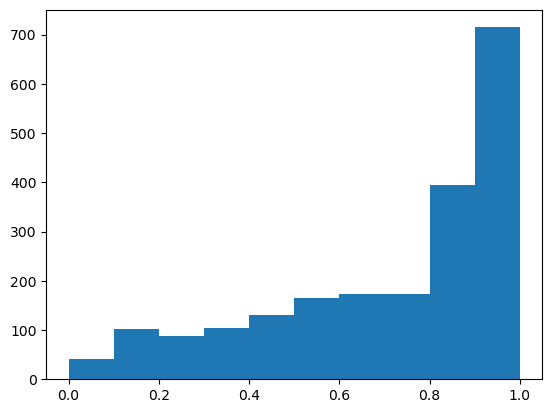

In [84]:
plt.hist(df.auc)

<AxesSubplot: xlabel='num_presences_cat', ylabel='auc'>

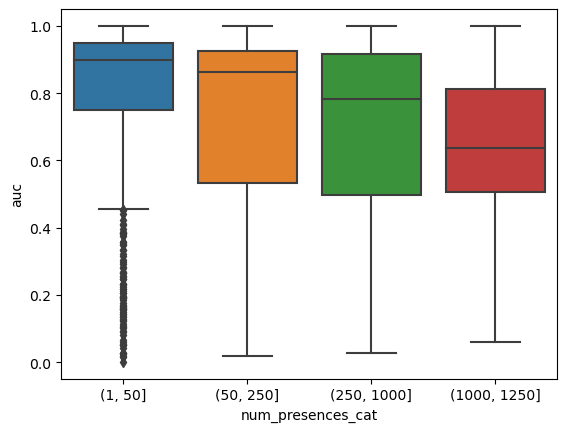

In [103]:
sns.boxplot(data=df, x="num_presences_cat", y="auc")


Text(0.5, 0.98, '0208_MLP_env_1_weighted_loss_1')

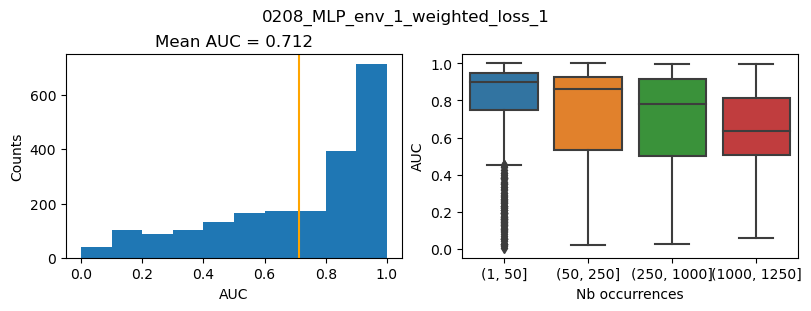

In [114]:
fig, (ax1, ax2) = plt.subplots(1, 2, layout='constrained', figsize=(8,3))

mean1 = df.auc.mean()
ax1.hist(df.auc)
ax1.axvline(mean1, color='orange')
ax1.set(xlabel='AUC', ylabel='Counts', title=f"Mean AUC = {mean1:.3f}")

sns.boxplot(data=df, x="num_presences_cat", y="auc", ax=ax2)
ax2.set(xlabel='Nb occurrences', ylabel='AUC')

fig.suptitle(run_name)



In [57]:
mean_weights = pd.DataFrame({
    'bioclim': weights[:,:512].mean(axis=1), 'sat': weights[:,512:].mean(axis=1)
}).sort_values(['bioclim','sat'])

In [61]:
mean_weights.values.shape

(2088, 2)

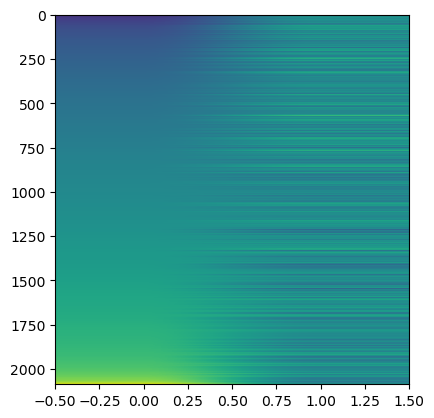

In [67]:
plt.imshow(mean_weights.values, aspect=0.001)

In [39]:
roc_auc_score(labels, y_pred)

0.7856477944925715

In [40]:
roc_auc_score(labels[:, low_occ_species_idx], y_pred[:, low_occ_species_idx])

0.8021208924074779

In [183]:
df = pd.DataFrame(train_data.species_counts, columns=['n_occ']).reset_index()
df['auc'] = [roc_auc_score(labels[:,i], y_pred[:,i]) for i in range(labels.shape[1])]
df

,index,n_occ,auc
0,1,2261,0.942233
1,5,4529,0.641626
2,10,2162,0.938100
3,11,4508,0.668044
4,24,4539,0.808725
...,...,...,...
2169,10028,204,0.913114
2170,10031,20,0.799381
2171,10035,110,0.467925
2172,10038,10,0.944332


<AxesSubplot: xlabel='n_occ', ylabel='auc'>

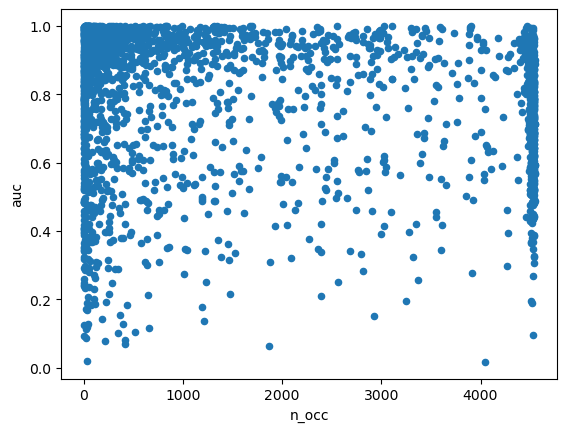

In [184]:
df.plot.scatter(x='n_occ', y='auc')

array([[<AxesSubplot: title={'center': 'auc'}>]], dtype=object)

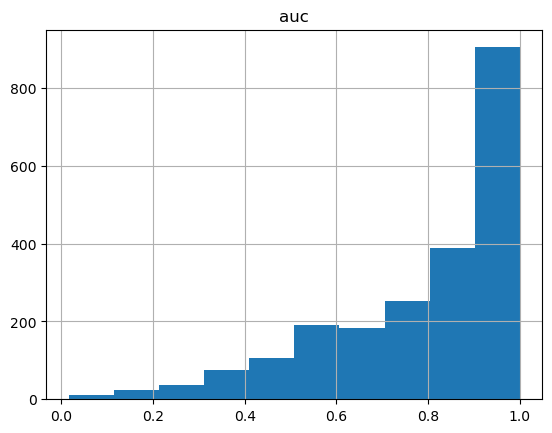

In [185]:
df.hist('auc')

In [132]:
f1_scores = {}

In [133]:
def compute_f1(labels, pred):
    tn, fp, fn, tp = confusion_matrix(labels, pred).ravel()
    f1 = tp / (tp + ((fp+fn)/2))
    return f1

In [148]:
np.arange(0.025, 1, 0.025)

array([0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  , 0.225,
       0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425, 0.45 ,
       0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 , 0.675,
       0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875, 0.9  ,
       0.925, 0.95 , 0.975])

In [141]:
for thresh in [0.725, 0.775, 0.825, 0.875]:#[0.1,0.2,0.3,0.4,0.5,0.6]:
    y_pred_bin = binarize(y_pred, threshold=thresh)
    f1_list = [compute_f1(labels[i,:], y_pred_bin[i,:]) for i in range(labels.shape[0])]
    f1_mean = np.mean(f1_list)
    print(thresh, '.... f1 = ', f1_mean)
    f1_scores[thresh] = f1_mean

0.725 .... f1 =  0.06117215804106441
0.775 .... f1 =  0.06264313190626879
0.825 .... f1 =  0.06173608953075929
0.875 .... f1 =  0.05883165026162659


In [142]:
dict(sorted(f1_scores.items()))

{0.1: 0.02710992021944885,
 0.2: 0.03364692441686345,
 0.3: 0.03942517650257939,
 0.4: 0.04484486907101754,
 0.5: 0.05034539790447907,
 0.6: 0.056212310325247414,
 0.7: 0.06004252688166328,
 0.725: 0.06117215804106441,
 0.75: 0.06217998207848221,
 0.775: 0.06264313190626879,
 0.8: 0.06277095937546352,
 0.825: 0.06173608953075929,
 0.85: 0.06166061019067241,
 0.875: 0.05883165026162659,
 0.9: 0.05529068820707533}

In [176]:
max_f1 = np.max(list(f1_scores.values()))
threshold = [k for k,v in f1_scores.items() if v == max_f1][0]
print('threshold', threshold)
print('max f1', max_f1)

threshold 0.8
max f1 0.06277095937546352


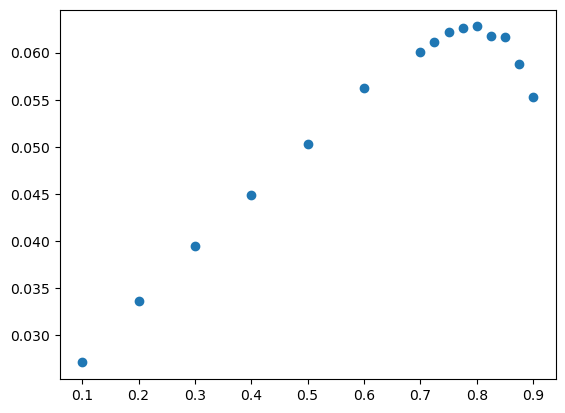

In [143]:
plt.scatter(x=f1_scores.keys(), y=f1_scores.values())

In [197]:
f1_scores

{0.1: 0.02710992021944885,
 0.2: 0.03364692441686345,
 0.3: 0.03942517650257939,
 0.4: 0.04484486907101754,
 0.5: 0.05034539790447907,
 0.6: 0.056212310325247414,
 0.7: 0.06004252688166328,
 0.8: 0.06277095937546352,
 0.9: 0.05529068820707533,
 0.75: 0.06217998207848221,
 0.85: 0.06166061019067241,
 0.725: 0.06117215804106441,
 0.775: 0.06264313190626879,
 0.825: 0.06173608953075929,
 0.875: 0.05883165026162659}

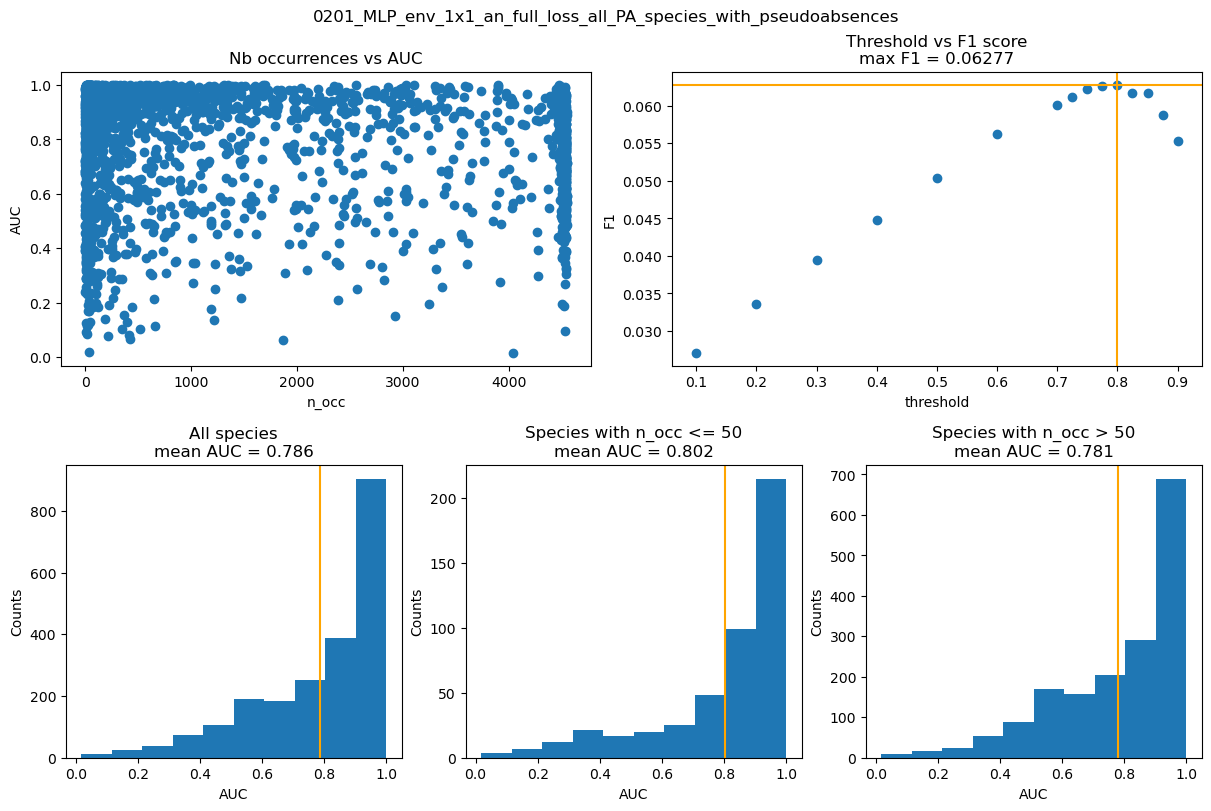

In [243]:
fig = plt.figure(layout='constrained', figsize=(12, 8))
subfigs = fig.subfigures(2, 1)

ax1, ax2 = subfigs[0].subplots(1, 2)
ax1.scatter(x=df.n_occ, y=df.auc)
ax1.set(xlabel='n_occ', ylabel='AUC', title='Nb occurrences vs AUC')

ax2.scatter(x=list(f1_scores.keys()), y=list(f1_scores.values()))
ax2.axhline(y=max_f1, color='orange')
ax2.axvline(x=threshold, color='orange')
ax2.set(xlabel='threshold', ylabel='F1', title=f"Threshold vs F1 score\nmax F1 = {max_f1:.5f}")

ax1, ax2, ax3 = subfigs[1].subplots(1, 3)
ax1.hist(df.auc)
mean1 = df.auc.mean()
ax1.axvline(mean1, color='orange')
ax1.set(xlabel='AUC', ylabel='Counts', title=f"All species\nmean AUC = {mean1:.3f}")

ax2.hist(df[df['n_occ'] <= n_max_low_occ].auc)
mean2 = df[df['n_occ'] <= n_max_low_occ].auc.mean()
ax2.axvline(mean2, color='orange')
ax2.set(xlabel='AUC', ylabel='Counts', title=f"Species with n_occ <= 50\nmean AUC = {mean2:.3f}")

ax3.hist(df[df['n_occ'] > n_max_low_occ].auc)
mean3 = df[df['n_occ'] > n_max_low_occ].auc.mean()
ax3.axvline(mean3, color='orange')
ax3.set(xlabel='AUC', ylabel='Counts', title=f"Species with n_occ > 50\nmean AUC = {mean3:.3f}")

fig.suptitle(run_name)
plt.savefig('test.png')